In [1]:
import warnings

# Ignore all warnings (not recommended unless you know what you are doing)
warnings.filterwarnings("ignore")
import os

In [5]:
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

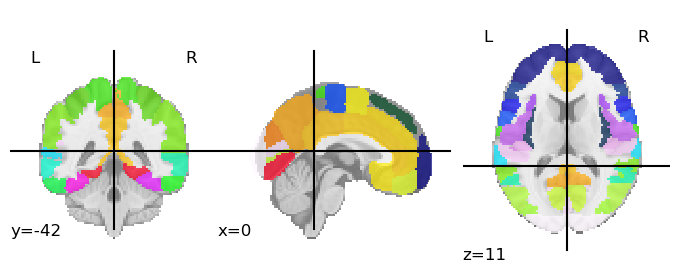

In [6]:
from nilearn import plotting
plotting.plot_roi(atlas_filename)

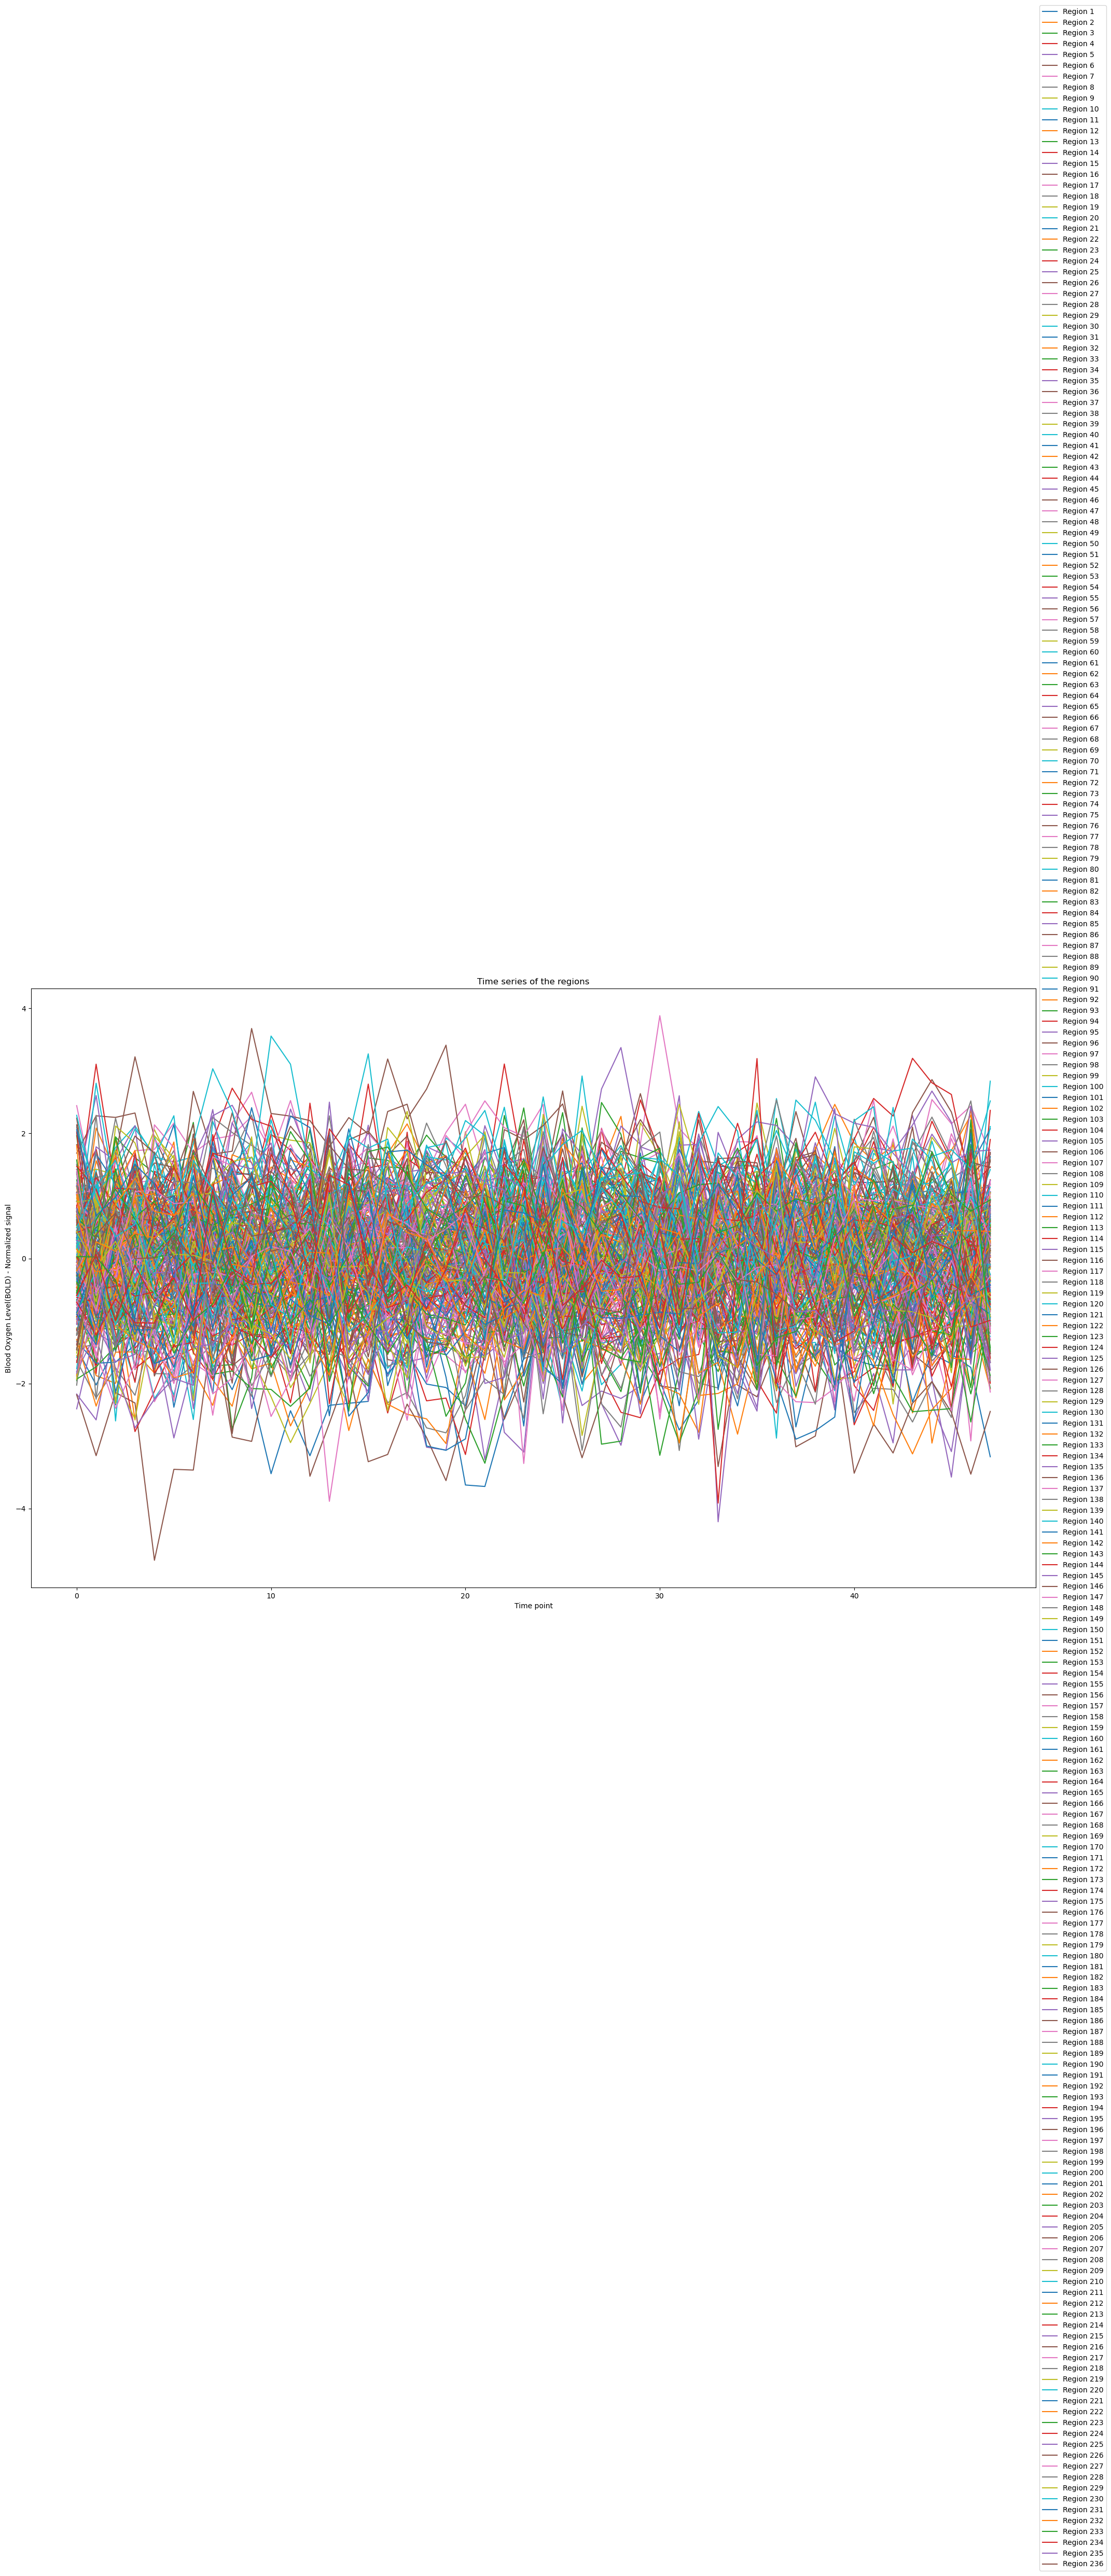

[[ 3.7443868   0.51856878 -0.90506136 ...  0.          0.
  -0.65541768]
 [ 0.51856878  5.89607796  0.         ...  0.          0.
   0.        ]
 [-0.90506136  0.          3.45909549 ...  0.         -0.52123355
   0.51980254]
 ...
 [ 0.          0.          0.         ...  7.10032461  0.
   0.        ]
 [ 0.          0.         -0.52123355 ...  0.          2.89726137
   0.        ]
 [-0.65541768  0.          0.51980254 ...  0.          0.
   5.0741098 ]]


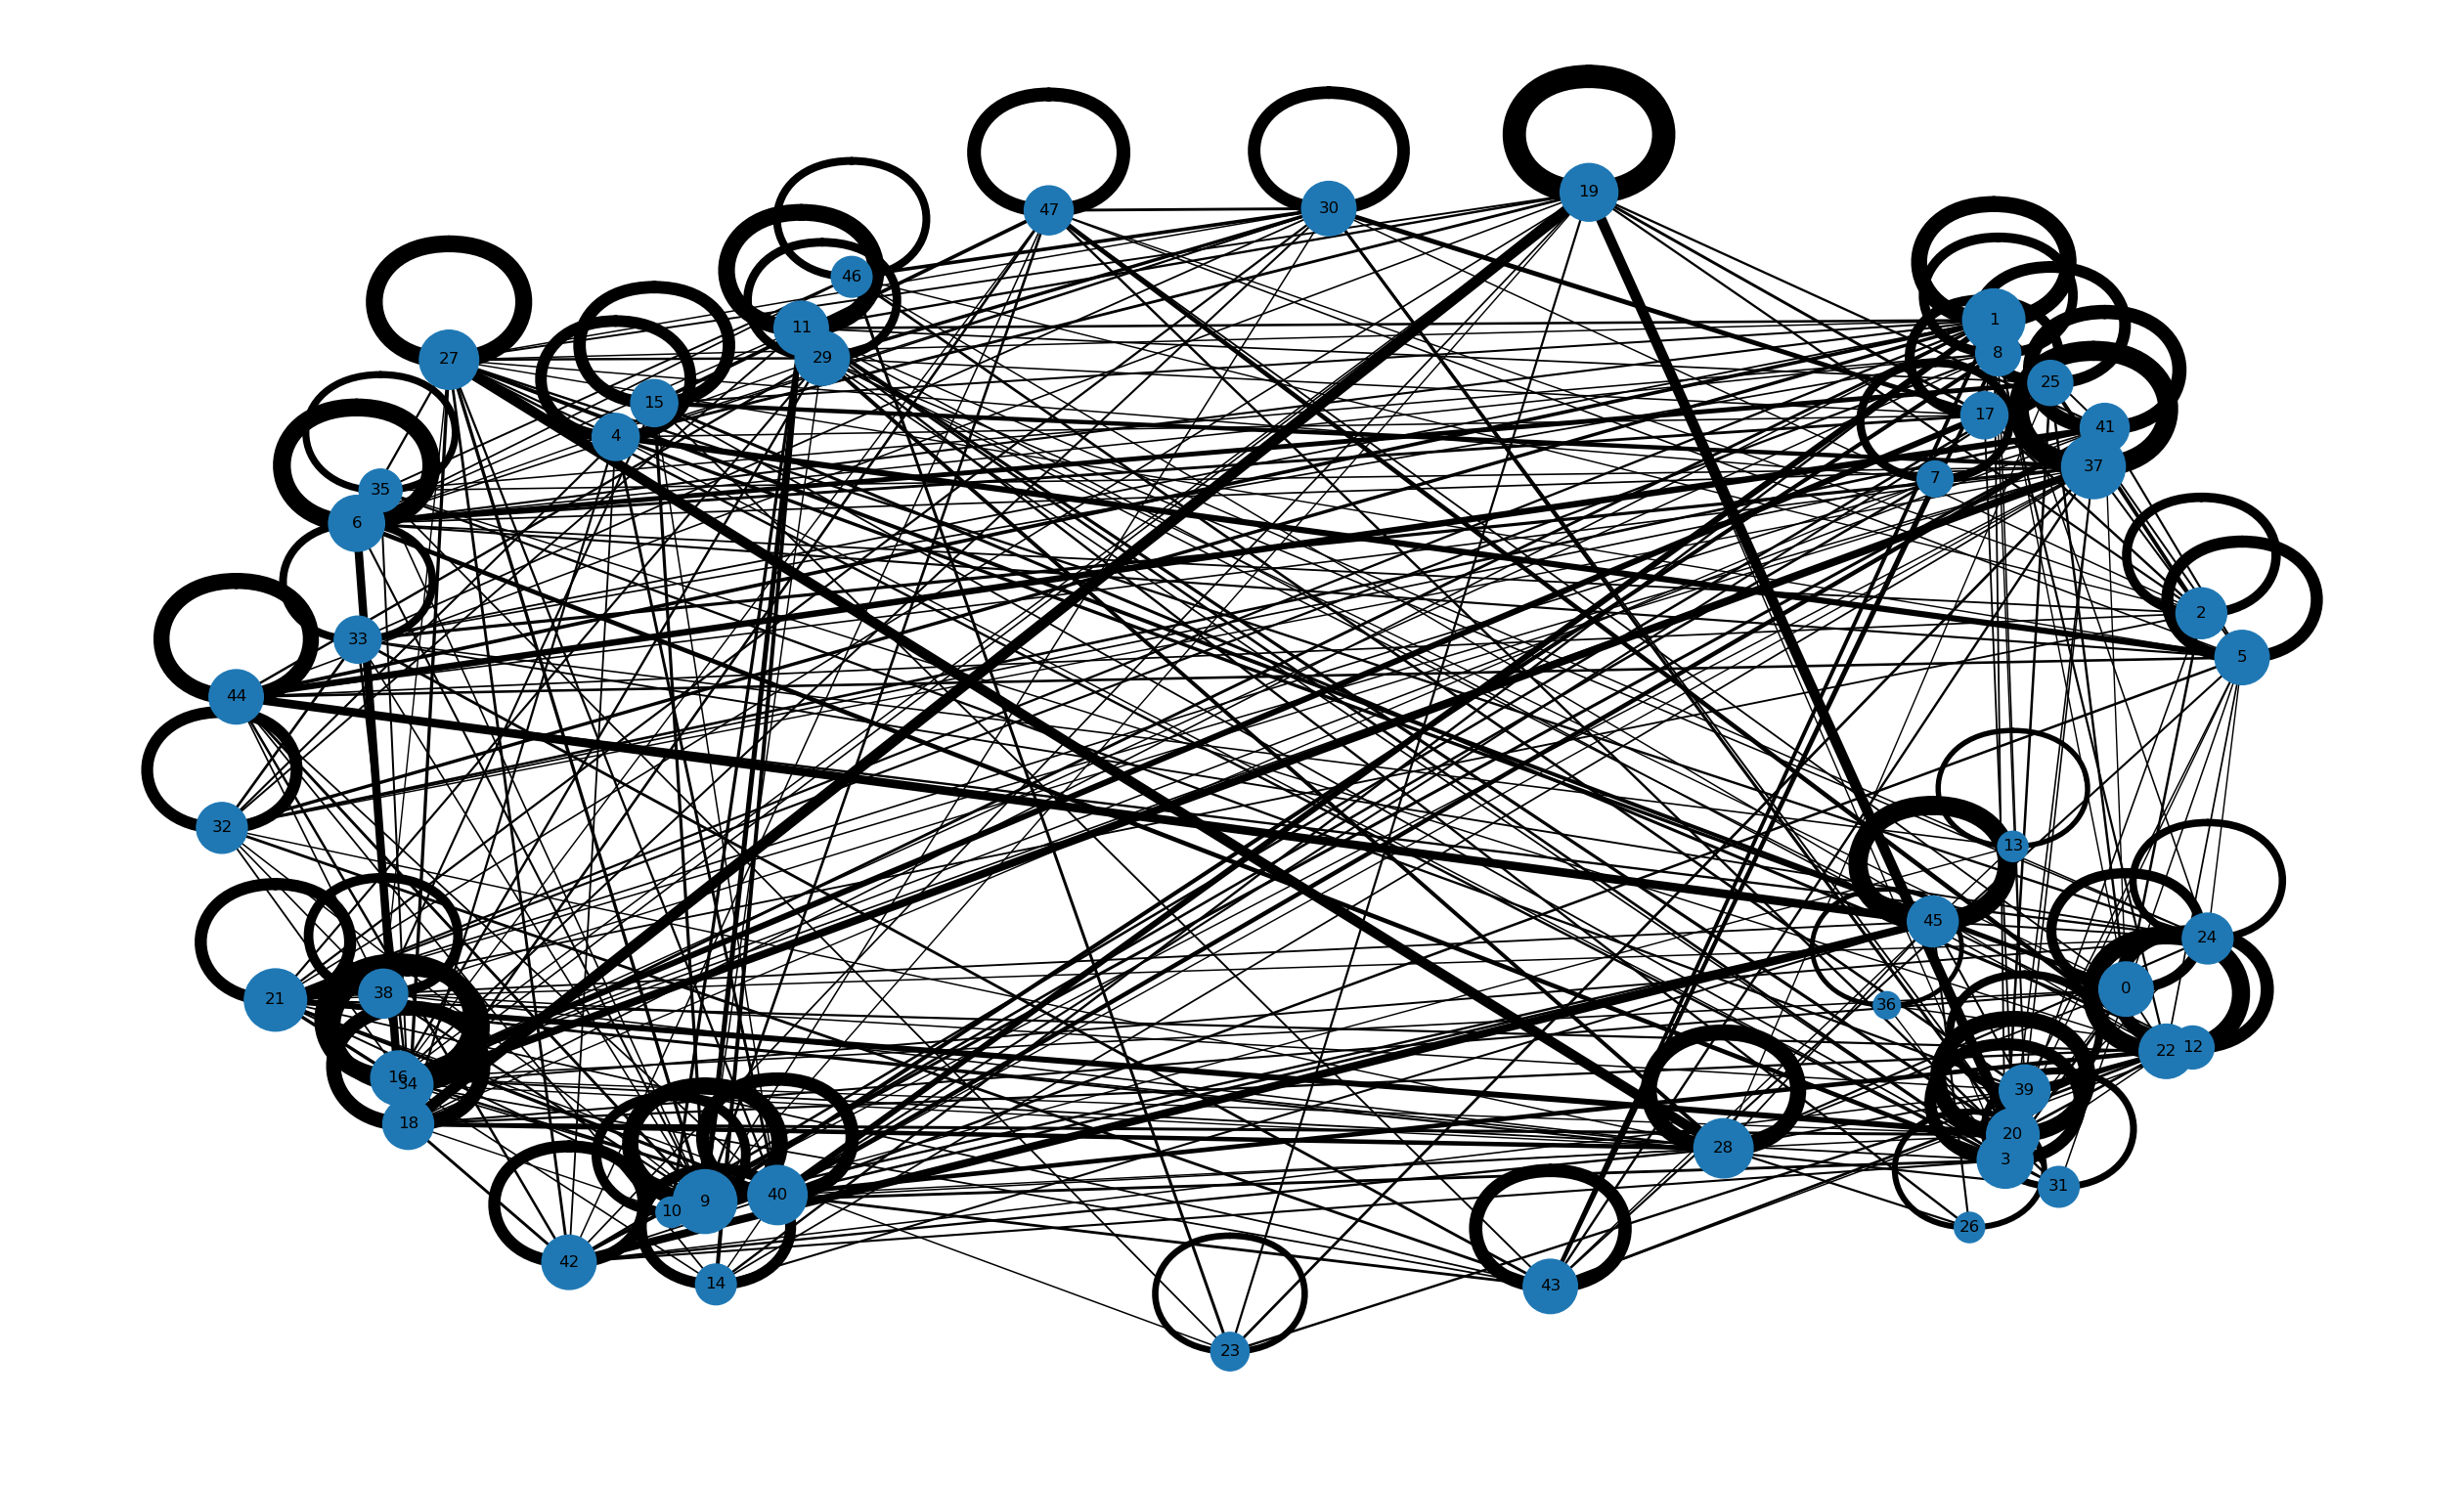

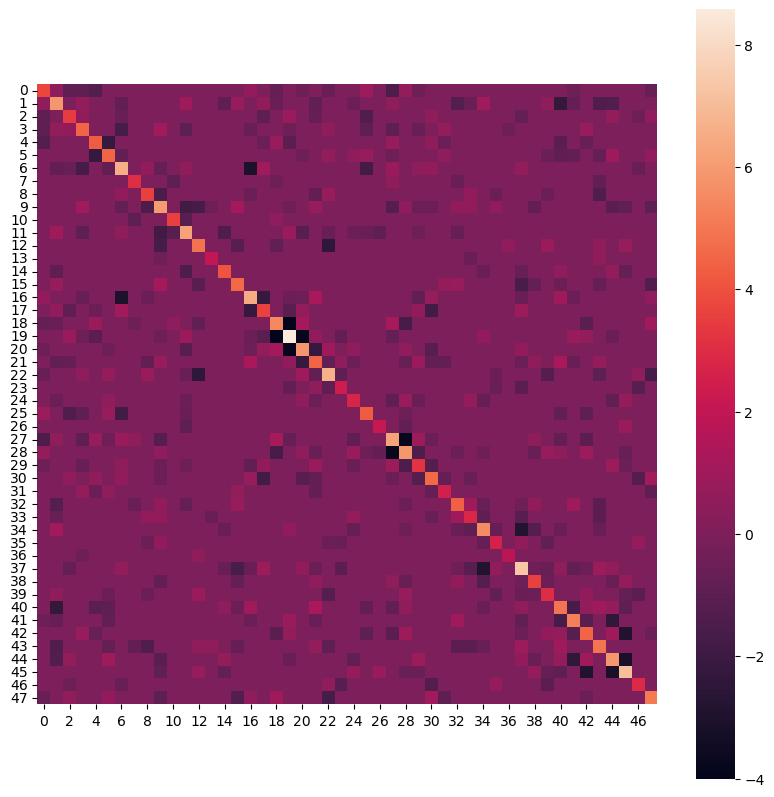

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import input_data, datasets
from nilearn.connectome import ConnectivityMeasure
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
csv_file = pd.read_csv(r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")

# Replace labels 1 and 2 with 0 and 1
csv_file['DX_GROUP'].replace({1: 0, 2: 1}, inplace=True)

# Split data into training and test sets
train_df, test_df = train_test_split(csv_file, test_size=0.2, random_state=42)

# Load the Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
masker = input_data.NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)

# MRI file directory
mri_dir = r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/cpac/nofilt_noglobal/"
# Placeholder for Graph Neural Network Data
graph_data_list = []

for idx, row in enumerate(train_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        n_regions, n_time_points = time_series.shape
        number_of_entries = n_regions * n_time_points

        '''print("Number of regions:", n_regions)
        print("Number of time points:", n_time_points)
        print("Total number of entries:", number_of_entries'''

        if idx == 0:  # Only for the first iteration
            # Plot the time series for the regions
            plt.figure(figsize=(25, 15))  # Increase the size of the plot
            for i in range(min(n_regions, time_series.shape[0])):
                plt.plot(time_series[i, :], label=f'Region {i + 1}')

            plt.xlabel('Time point')
            plt.ylabel('Blood Oxygen Level(BOLD) - Normalized signal')
            plt.title('Time series of the regions')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend to the right of the plot
            plt.tight_layout()  # Adjust the layout to fit the plot and labels
            plt.show()

        # Create an adjacency matrix based on ROI correlations
        correlation_measure = ConnectivityMeasure(kind='precision')
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]

        # Threshold the correlation matrix (optional)
        threshold = 0.5  # Set the threshold value for the correlation
        correlation_matrix[abs(correlation_matrix) < threshold] = 0

        # Generate graph from correlation matrix
        G = nx.from_numpy_matrix(correlation_matrix)

        if idx == 0:  # Only for the first iteration
            print(correlation_matrix)

            # Step 6: Visualize the graph
            plt.figure(figsize=(25, 15))  # Increase the size of the plot
            pos = nx.spring_layout(G)  # Use spring layout
            node_sizes = [100 * np.abs(G.degree(n)) for n in G.nodes]  # Size nodes by their degree
            edge_widths = [2 * np.abs(G[u][v]['weight']) for u, v in G.edges]  # Width edges by their weight
            nx.draw(G, pos, node_size=node_sizes, width=edge_widths, with_labels=True)
            plt.show()

            # Plot the correlation matrix
            plt.figure(figsize=(10, 10))
            sns.heatmap(correlation_matrix, square=True)
            plt.show()

        # Generate edges and features for PyTorch Geometric
        edge_index = torch.tensor(list(G.edges), dtype=torch.long)
        x = torch.tensor(time_series, dtype=torch.float)
        y = torch.tensor([row.DX_GROUP], dtype=torch.float)

        # Create graph data for PyTorch Geometric
        data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

        # Append data to list
        graph_data_list.append(data)
    except FileNotFoundError:
        pass


In [3]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine the number of features and classes
num_features = graph_data_list[0].num_node_features
num_classes = 2  # Autistic and non-autistic

# Instantiate the model and optimizer
model = Net(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create a data loader
loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

# Model Training
for epoch in range(100):
    total_loss = 0
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

# Model Evaluation
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    _, pred = model(data).max(dim=1)
    correct += int((pred == data.y.long()).sum())
print('Accuracy: {:.4f}'.format(correct/len(loader.dataset)))


Epoch: 1, Loss: 0.7068856737830422
Epoch: 2, Loss: 0.6984805220907385
Epoch: 3, Loss: 0.6889863176779314
Epoch: 4, Loss: 0.6845013038678602
Epoch: 5, Loss: 0.6935454471544786
Epoch: 6, Loss: 0.6806466985832561
Epoch: 7, Loss: 0.6634989407929507
Epoch: 8, Loss: 0.6685694672844626
Epoch: 9, Loss: 0.6500948559154164
Epoch: 10, Loss: 0.6259123222394423
Epoch: 11, Loss: 0.6330401721325788
Epoch: 12, Loss: 0.6025139797817577
Epoch: 13, Loss: 0.5987118875438516
Epoch: 14, Loss: 0.6024108014323495
Epoch: 15, Loss: 0.5985253073952415
Epoch: 16, Loss: 0.5835990052331578
Epoch: 17, Loss: 0.5806507793339816
Epoch: 18, Loss: 0.5432954891161486
Epoch: 19, Loss: 0.5670767575502396
Epoch: 20, Loss: 0.5394139222123406
Epoch: 21, Loss: 0.5304450609467246
Epoch: 22, Loss: 0.5160923884673552
Epoch: 23, Loss: 0.5333492904901505
Epoch: 24, Loss: 0.533288982781497
Epoch: 25, Loss: 0.5154206563125957
Epoch: 26, Loss: 0.49526881223375147
Epoch: 27, Loss: 0.49747634611346503
Epoch: 28, Loss: 0.509456293149428
E

Test Accuracy: 0.6398


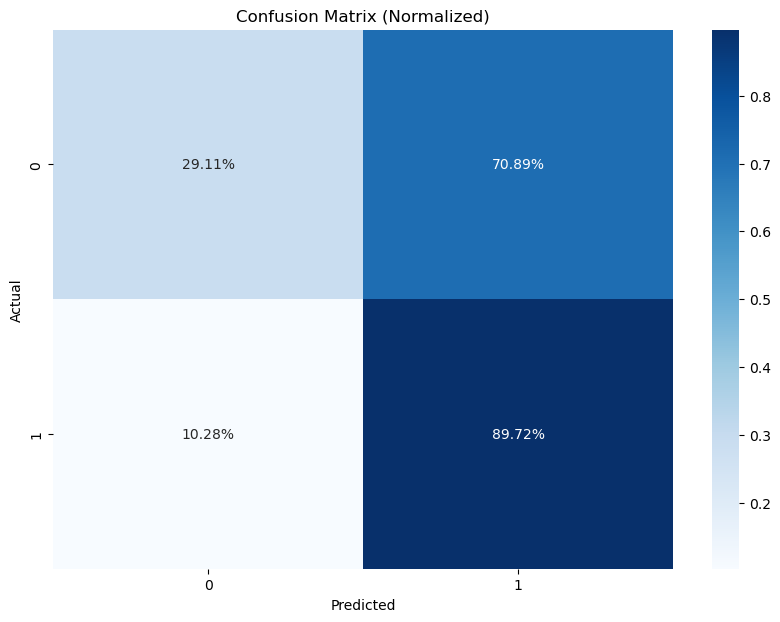

     Actual  Predicted
0       0.0          1
1       1.0          1
2       1.0          1
3       0.0          1
4       1.0          0
..      ...        ...
181     1.0          1
182     1.0          1
183     0.0          0
184     0.0          1
185     1.0          1

[186 rows x 2 columns]
              precision    recall  f1-score   support

Non-Autistic       0.68      0.29      0.41        79
    Autistic       0.63      0.90      0.74       107

    accuracy                           0.64       186
   macro avg       0.65      0.59      0.57       186
weighted avg       0.65      0.64      0.60       186



In [4]:
# Placeholder for Graph Neural Network Data for testing
graph_data_test_list = []

for idx, row in enumerate(test_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        # Create an adjacency matrix based on ROI correlations
        correlation_measure = ConnectivityMeasure(kind='precision')
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]

        # Threshold the correlation matrix (optional)
        threshold = 0.5  # Set the threshold value for the correlation
        correlation_matrix[abs(correlation_matrix) < threshold] = 0

        # Generate graph from correlation matrix
        G = nx.from_numpy_matrix(correlation_matrix)

        # Generate edges and features for PyTorch Geometric
        edge_index = torch.tensor(list(G.edges), dtype=torch.long)
        x = torch.tensor(time_series, dtype=torch.float)
        y = torch.tensor([row.DX_GROUP], dtype=torch.float)

        # Create graph data for PyTorch Geometric
        data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

        # Append data to list
        graph_data_test_list.append(data)
    except FileNotFoundError:
        pass

# Create a data loader for testing data
test_loader = DataLoader(graph_data_test_list, batch_size=32, shuffle=False)

# Testing
model.eval()
correct = 0
all_preds = []
all_labels = []

for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        _, pred = output.max(dim=1)
    all_preds.append(pred.cpu().numpy())
    all_labels.append(data.y.cpu().numpy())
    correct += int((pred == data.y.long()).sum())

accuracy = correct / len(test_loader.dataset)

print(f'Test Accuracy: {accuracy:.4f}')

# Flatten the list of predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

'''cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# Print actual vs predicted
actual_vs_predicted = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds})
print(actual_vs_predicted)


# Classification report
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic']))


GCN - Epoch: 1, Loss: 0.7035509754310955
GCN - Epoch: 2, Loss: 0.6872066205198114
GCN - Epoch: 3, Loss: 0.6747447170994498
GCN - Epoch: 4, Loss: 0.6781867796724493
GCN - Epoch: 5, Loss: 0.6645026694644581
GCN - Epoch: 6, Loss: 0.653383347121152
GCN - Epoch: 7, Loss: 0.6259868903593584
GCN - Epoch: 8, Loss: 0.6455159986560995
GCN - Epoch: 9, Loss: 0.613254735415632
GCN - Epoch: 10, Loss: 0.615544939582998
GCN - Epoch: 11, Loss: 0.5871093015779149
GCN - Epoch: 12, Loss: 0.5852867744185708
GCN - Epoch: 13, Loss: 0.5731925774704326
GCN - Epoch: 14, Loss: 0.5604045201431621
GCN - Epoch: 15, Loss: 0.5547157959504561
GCN - Epoch: 16, Loss: 0.5774155814539302
GCN - Epoch: 17, Loss: 0.5453175983645699
GCN - Epoch: 18, Loss: 0.5518420419909738
GCN - Epoch: 19, Loss: 0.5069263604554263
GCN - Epoch: 20, Loss: 0.5285226269201799
GCN - Epoch: 21, Loss: 0.49254645000804553
GCN - Epoch: 22, Loss: 0.5184286439960654
GCN - Epoch: 23, Loss: 0.5130534808744084
GCN - Epoch: 24, Loss: 0.5832936370914633
GCN

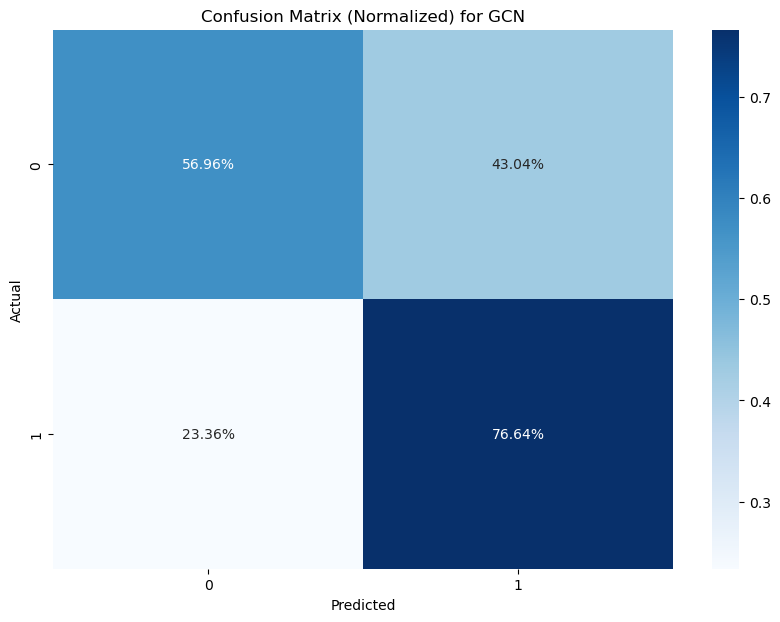

GAT - Epoch: 1, Loss: 0.7035074532032013
GAT - Epoch: 2, Loss: 0.6880273114551197
GAT - Epoch: 3, Loss: 0.6947785968130286
GAT - Epoch: 4, Loss: 0.6687172001058405
GAT - Epoch: 5, Loss: 0.6759442741220648
GAT - Epoch: 6, Loss: 0.6825319149277427
GAT - Epoch: 7, Loss: 0.6552610749548132
GAT - Epoch: 8, Loss: 0.637387137521397
GAT - Epoch: 9, Loss: 0.624552384018898
GAT - Epoch: 10, Loss: 0.6274858076464046
GAT - Epoch: 11, Loss: 0.5965242358771238
GAT - Epoch: 12, Loss: 0.6110938611355695
GAT - Epoch: 13, Loss: 0.5973311134360053
GAT - Epoch: 14, Loss: 0.5805700150403109
GAT - Epoch: 15, Loss: 0.581598783081228
GAT - Epoch: 16, Loss: 0.5557799935340881
GAT - Epoch: 17, Loss: 0.5922395844351162
GAT - Epoch: 18, Loss: 0.5424054170196707
GAT - Epoch: 19, Loss: 0.5366924066435207
GAT - Epoch: 20, Loss: 0.5233826772733168
GAT - Epoch: 21, Loss: 0.5216798877174204
GAT - Epoch: 22, Loss: 0.5049284263090654
GAT - Epoch: 23, Loss: 0.5060384368354623
GAT - Epoch: 24, Loss: 0.519544933329929
GAT -

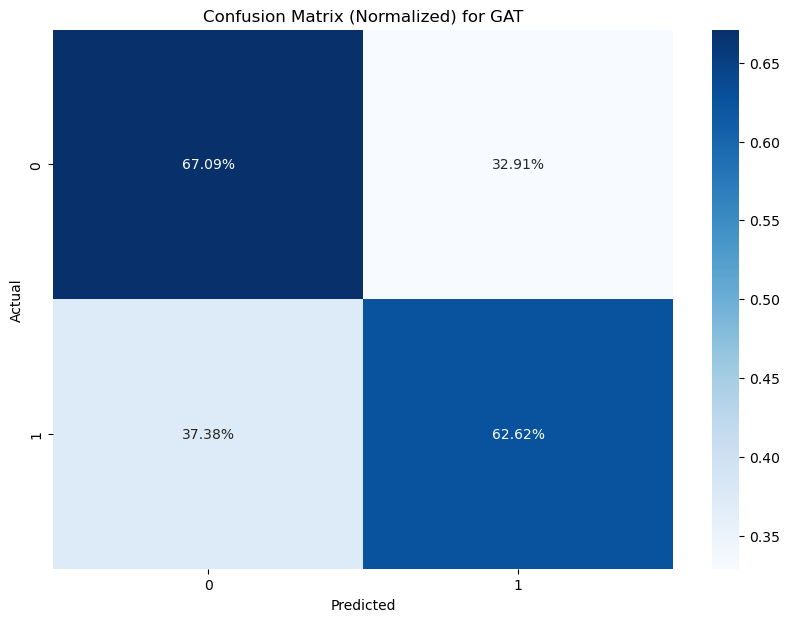

SAGE - Epoch: 1, Loss: 0.7006902911446311
SAGE - Epoch: 2, Loss: 0.6907620375806635
SAGE - Epoch: 3, Loss: 0.6786052476276051
SAGE - Epoch: 4, Loss: 0.665870875120163
SAGE - Epoch: 5, Loss: 0.6404368660666726
SAGE - Epoch: 6, Loss: 0.6089779084379022
SAGE - Epoch: 7, Loss: 0.6032644266431982
SAGE - Epoch: 8, Loss: 0.6043969731439244
SAGE - Epoch: 9, Loss: 0.5848172469572588
SAGE - Epoch: 10, Loss: 0.5770480808886614
SAGE - Epoch: 11, Loss: 0.5786635049364783
SAGE - Epoch: 12, Loss: 0.5460411201823842
SAGE - Epoch: 13, Loss: 0.5711602907289158
SAGE - Epoch: 14, Loss: 0.5280901383269917
SAGE - Epoch: 15, Loss: 0.5308527783914045
SAGE - Epoch: 16, Loss: 0.5508144795894623
SAGE - Epoch: 17, Loss: 0.5292143103751269
SAGE - Epoch: 18, Loss: 0.49750111319802026
SAGE - Epoch: 19, Loss: 0.516432758082043
SAGE - Epoch: 20, Loss: 0.5108538432554766
SAGE - Epoch: 21, Loss: 0.4917895739728754
SAGE - Epoch: 22, Loss: 0.47461945902217517
SAGE - Epoch: 23, Loss: 0.4798929596489126
SAGE - Epoch: 24, Lo

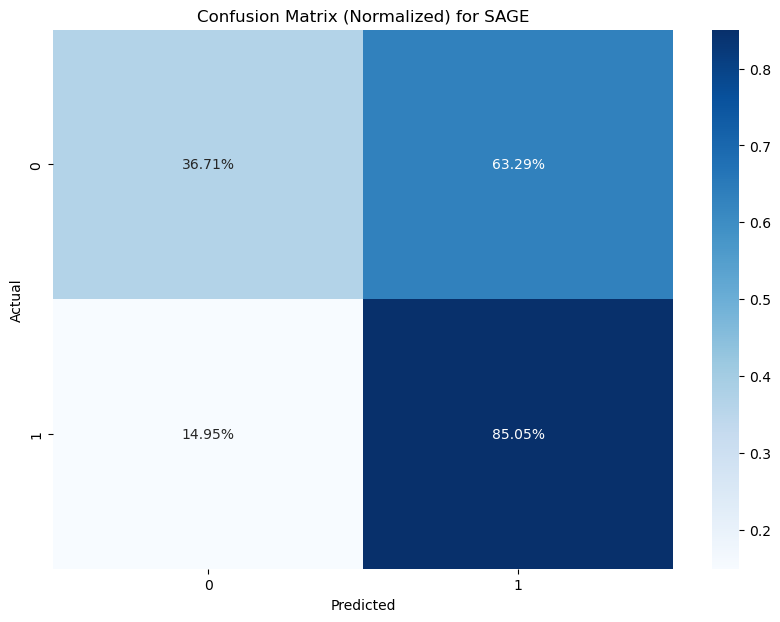

GIN - Epoch: 1, Loss: 0.6964955302802
GIN - Epoch: 2, Loss: 0.6951533285054293
GIN - Epoch: 3, Loss: 0.690773527730595
GIN - Epoch: 4, Loss: 0.6870031573555686
GIN - Epoch: 5, Loss: 0.6968315623023293
GIN - Epoch: 6, Loss: 0.6915242997082797
GIN - Epoch: 7, Loss: 0.6793652772903442
GIN - Epoch: 8, Loss: 0.6746075803583319
GIN - Epoch: 9, Loss: 0.6784929958256808
GIN - Epoch: 10, Loss: 0.6637119217352434
GIN - Epoch: 11, Loss: 0.6582588634707711
GIN - Epoch: 12, Loss: 0.6336291242729534
GIN - Epoch: 13, Loss: 0.6424469162117351
GIN - Epoch: 14, Loss: 0.6216438819061626
GIN - Epoch: 15, Loss: 0.5883296592669054
GIN - Epoch: 16, Loss: 0.5881975103508342
GIN - Epoch: 17, Loss: 0.5711987018585205
GIN - Epoch: 18, Loss: 0.5702883032235232
GIN - Epoch: 19, Loss: 0.562506996772506
GIN - Epoch: 20, Loss: 0.5250959613106467
GIN - Epoch: 21, Loss: 0.5053965720263395
GIN - Epoch: 22, Loss: 0.4973603297363628
GIN - Epoch: 23, Loss: 0.5032557885755192
GIN - Epoch: 24, Loss: 0.470886078747836
GIN - E

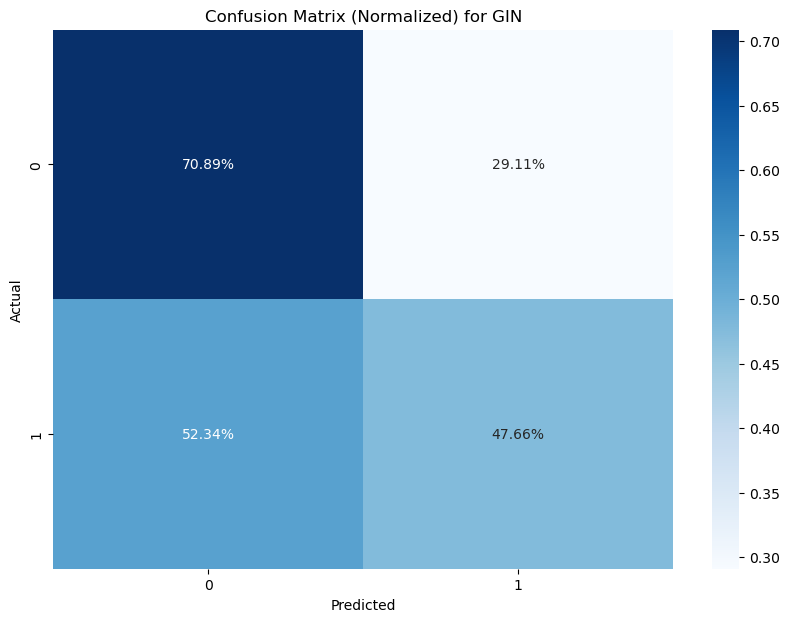

  Model  Train_Accuracy  Test_Accuracy  Precision    Recall  F1-Score
0   GCN        0.937226       0.682796   0.674877  0.667988  0.669726
1   GAT        0.921168       0.645161   0.645161  0.648527  0.643140
2  SAGE        0.940146       0.645161   0.644917  0.608778  0.600806
3   GIN        0.956204       0.575269   0.594595  0.592748  0.574962


In [11]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.data import DataLoader
import pandas as pd

class Net(torch.nn.Module):
    def __init__(self, conv_layer, num_node_features, num_classes):
        super(Net, self).__init__()
        if conv_layer == GINConv:
            nn1 = torch.nn.Sequential(torch.nn.Linear(num_node_features, 16), torch.nn.ReLU(), torch.nn.Linear(16, 16))
            self.conv1 = conv_layer(nn1)
            nn2 = torch.nn.Sequential(torch.nn.Linear(16, 32), torch.nn.ReLU(), torch.nn.Linear(32, 32))
            self.conv2 = conv_layer(nn2)
        else:
            self.conv1 = conv_layer(num_node_features, 16)
            self.conv2 = conv_layer(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    
# Define models and their names
models = [GCNConv, GATConv, SAGEConv, GINConv]
model_names = ['GCN', 'GAT', 'SAGE', 'GIN']

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy"])


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy", "Precision", "Recall", "F1-Score"])

# Model Training and Evaluation for each Convolution Layer
for model_name, model_class in zip(model_names, models):
    model = Net(model_class, num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training
    for epoch in range(100):
        total_loss = 0
        model.train()
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'{model_name} - Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

    # Evaluation on Training Data
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        _, pred = model(data).max(dim=1)
        correct += int((pred == data.y.long()).sum())
    train_accuracy = correct / len(loader.dataset)
    print(f'{model_name} Train Accuracy: {train_accuracy:.4f}')

    # Evaluation on Test Data
    correct = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            _, pred = output.max(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
        correct += int((pred == data.y.long()).sum())
    test_accuracy = correct / len(test_loader.dataset)
    print(f'{model_name} Test Accuracy: {test_accuracy:.4f}')

    # Flatten the list of predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Normalized) for {model_name}')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic'], output_dict=True)

    # Append the accuracy to the results DataFrame
    results = results.append({
        "Model": model_name,
        "Train_Accuracy": train_accuracy,
        "Test_Accuracy": test_accuracy,
        "Precision": report['macro avg']['precision'],
        "Recall": report['macro avg']['recall'],
        "F1-Score": report['macro avg']['f1-score'],
    }, ignore_index=True)

print(results)



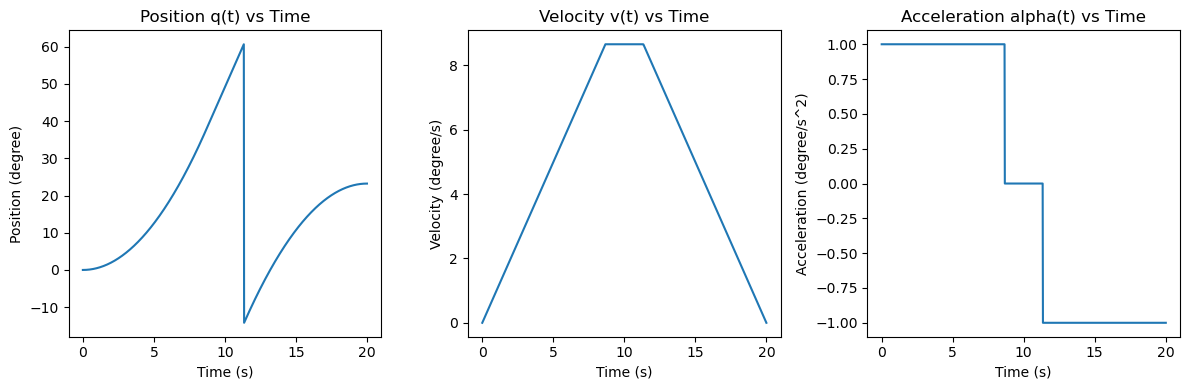

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Time intervals
t_a = math.sqrt(75)
t_c = 20 - 2 * t_a
v_const = math.sqrt(75)

# Time range
t = np.linspace(0, 20, 1000)

# Position, velocity, and acceleration trajectories
q = np.piecewise(t,
                 [t < t_a, (t >= t_a) & (t < t_a + t_c), t >= t_a + t_c],
                 [lambda t: 0.5 * t ** 2,
                  lambda t: 75/2 + v_const * (t - t_a),
                  lambda t: 75/2 + v_const * (t - 2*t_a) - 0.5 * (t - t_a - t_c)**2])

v = np.piecewise(t,
                 [t < t_a, (t >= t_a) & (t < t_a + t_c), t >= t_a + t_c],
                 [lambda t: t,
                  lambda t: v_const,
                  lambda t: v_const - (t - t_a - t_c)])

alpha = np.piecewise(t,
                     [t < t_a, (t >= t_a) & (t < t_a + t_c), t >= t_a + t_c],
                     [1, 0, -1])

# Plot position
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(t, q)
plt.title('Position q(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (degree)')

# Plot velocity
plt.subplot(1, 3, 2)
plt.plot(t, v)
plt.title('Velocity v(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (degree/s)')

# Plot acceleration
plt.subplot(1, 3, 3)
plt.plot(t, alpha)
plt.title('Acceleration alpha(t) vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (degree/s^2)')

plt.tight_layout()
plt.show()
